[View in Colaboratory](https://colab.research.google.com/github/fabiansd/AI-workshop/blob/master/House_price_prediction_showcase.ipynb)

# House proce prediction

## initialization script

This is a initialization code. Run this and ignore it for now

In [0]:
## Import of libraries
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

## Option settings
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#############################################################################

## Function that converts categorical variables to integer-encoded varables
def encode_variables(data_modell):
  from sklearn import preprocessing

  ## Make encoder objects
  Neighborhood_enc = preprocessing.LabelEncoder()
  Condition1_enc = preprocessing.LabelEncoder()
  HouseStyle_enc = preprocessing.LabelEncoder()
  Fence_enc = preprocessing.LabelEncoder()
  PoolQualityCondition_enc = preprocessing.LabelEncoder()
  LandContour_enc = preprocessing.LabelEncoder()
  Heating_enc = preprocessing.LabelEncoder()

  ## Convert categorical columns
  data_modell['Neighborhood'] = Neighborhood_enc.fit_transform(data_modell['Neighborhood'])
  data_modell['Condition1'] = Condition1_enc.fit_transform(data_modell['Condition1'])
  data_modell['HouseStyle'] = HouseStyle_enc.fit_transform(data_modell['HouseStyle'])
  data_modell['Fence'] = Fence_enc.fit_transform(data_modell['Fence'])
  data_modell['PoolQC'] = PoolQualityCondition_enc.fit_transform(data_modell['PoolQC'])
  data_modell['LandContour'] = LandContour_enc.fit_transform(data_modell['LandContour'])
  data_modell['Heating'] = Heating_enc.fit_transform(data_modell['Heating'])
  
  return data_modell

## Function that plots a correlation plot over the features in the dataset
def correlation_plot(data, figsize = (18,16)):
  sns.set(style="white")

  # Compute the correlation matrix
  corr = data.corr()

  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=figsize)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap,annot = True,fmt = ".2f", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
def correlation_scatter(feature1, feature2, data, figsize=(15, 10), color = 'black'):
  plt.figure(figsize=figsize)
  plt.scatter(data[feature1], data[feature2], color=color)
  plt.xlabel(feature1)
  plt.ylabel(feature2)
  plt.title(feature1 + ' correlation with ' + feature2)
  plt.legend(loc='upper left')
  plt.show()

def distribution_numreic_features(feature, data, figsize=(15,7)):
  #Lab figur-objekt og bestem størrelsen
  plt.figure(figsize=figsize)

  #Velg type plot med sns (seaborn) biblioteket.
  sns.distplot(data[feature],bins=50, kde=False);

  #X- og y-aksen kan navngis
  plt.ylabel('Distribution amount')
  plt.xlabel(feature)


  #Sett tittel på figur
  plt.title('Distribution of ' + feature)
  plt.show()
  
def distribution_categorical_features(feature, data, sub_feature = None, figsize=(15,7)):
  plt.figure(figsize=figsize)
  plt.xticks(rotation=90)
  if sub_feature != None:
    sns.countplot(x=feature, hue=sub_feature, data=data)
    plt.title('Distribution of ' + feature + ' within ' + sub_feature)
  else: 
    sns.countplot(x=feature, data=data)
  
    plt.title('Distribution of ' + feature)
  
  
def split_data_function(data):
  
  from sklearn.model_selection import train_test_split

  ## Input data is all columns except the last, output data is the last column
  input_data = data.iloc[:,0:-1].copy(deep=True)
  output_data = data['SalePrice'].copy(deep=True)

  return train_test_split(input_data, output_data, test_size=0.2, random_state=1)

def prediction_result_plot(true_saleprice, predicted_saleprice, figsize=(15, 10)):
  plt.figure(figsize=figsize)
  plt.scatter(x=true_saleprice, y=predicted_saleprice)
  plt.xlabel('True Saleprice')
  plt.ylabel('Predicted Saleprice')
  plt.title('Prediction result -- truth against prediction')
  plt.show()

## Download dataset from Github into the script
from six.moves import urllib
urllib.request.urlretrieve("https://raw.githubusercontent.com/fabiansd/AI-workshop/master/data/Melbourne_train.csv", "./Melbourne_train.csv")
data = pd.read_csv('Melbourne_train.csv')

# Select a number of columns to include
aktuelle_kolonner = ['Id','LotArea','Neighborhood','WoodDeckSF','Condition1','HouseStyle','LandContour','OverallQual','OverallCond','YearBuilt','YearRemodAdd','Heating','1stFlrSF','FullBath','HalfBath','BedroomAbvGr','Fence','KitchenAbvGr','TotRmsAbvGrd','GarageCars','GarageArea','Fireplaces','PoolArea','PoolQC','MoSold','YrSold']
data_modell = data[aktuelle_kolonner]

# Generating new feature based on other features
data_modell['HouseAge'] = data['YrSold'] - data['YearBuilt']

#Fence NaN changed to None
data_modell['Fence'] = data_modell['Fence'].fillna('None')

#Adding saleprice on the end
data_modell['SalePrice'] = data['SalePrice']

#Removal of extreme points
data_modell = data_modell[data['LotArea'] < 100000]

## Getting started

Python alows users to use pre-made functions from various libraries. The libraries has to be **imported** in order to use them. Once imported, their functions can be used by defining what library, followed by dot and what function to use. E.g.:

library.function()


### Running a notebook

To run a code: press ctrl + enter or press play on the left top corner of the code block.

See all shortcuts on "Tools" or press Ctrl + m + h

Remember that you run code sequentally. If you try to use a variable/object from an earlier code block, this code block must have been run. If not, the notebook will not find the variable/object.


### Python library documentation

Pandas (data processing) <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html">dokumentasjon</a> og <a href="https://pandas.pydata.org/pandas-docs/stable/10min.html#min">tutorial</a> <br> 


Matplotlib (plot functions) <a href="https://matplotlib.org/gallery/index.html"> dokumentasjon </a> og <a href="https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python">tutorial </a> <br>

Scikit-learn (machine learning library) <a href="http://scikit-learn.org/stable/" > dokumentasjon </a> og <a href="http://scikit-learn.org/stable/tutorial/index.html"> tutorial </a> <br>

In python, the **Scikit-learn** library is called **sklearn** for simplicity

Dont forget to google, often!

# Explore data

## Pandas dataframe

 <a href="https://www.kaggle.com/c/home-data-for-ml-course/data"> Description </a> of Melbourne house sale dataset on Kaggle
 
 We use Pandas to read the dataset and load it into the python script. Pandas offers a lot of functions that allows us to explore the data.

In [62]:
#Print first n samples in dataset
data_modell.head(15)

,Id,LotArea,Neighborhood,WoodDeckSF,Condition1,HouseStyle,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Heating,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,Fence,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,PoolArea,PoolQC,MoSold,YrSold,HouseAge,SalePrice
0,1,8450,CollgCr,0,Norm,2Story,Lvl,7,5,2003,2003,GasA,856,2,1,3,None,1,8,2,548,0,0,NaN,2,2008,5,208500
1,2,9600,Veenker,298,Feedr,1Story,Lvl,6,8,1976,1976,GasA,1262,2,0,3,None,1,6,2,460,1,0,NaN,5,2007,31,181500
2,3,11250,CollgCr,0,Norm,2Story,Lvl,7,5,2001,2002,GasA,920,2,1,3,None,1,6,2,608,1,0,NaN,9,2008,7,223500
3,4,9550,Crawfor,0,Norm,2Story,Lvl,7,5,1915,1970,GasA,961,1,0,3,None,1,7,3,642,1,0,NaN,2,2006,91,140000
4,5,14260,NoRidge,192,Norm,2Story,Lvl,8,5,2000,2000,GasA,1145,2,1,4,None,1,9,3,836,1,0,NaN,12,2008,8,250000
5,6,14115,Mitchel,40,Norm,1.5Fin,Lvl,5,5,1993,1995,GasA,796,1,1,1,MnPrv,1,5,2,480,0,0,NaN,10,2009,16,143000
6,7,10084,Somerst,255,Norm,1Story,Lvl,8,5,2004,2005,GasA,1694,2,0,3,None,1,7,2,636,1,0,NaN,8,2007,3,307000
7,8,10382,NWAmes,235,PosN,2Story,Lvl,7,6,1973,1973,GasA,1107,2,1,3,None,1,7,2,484,2,0,NaN,11,2009,36,200000
8,9,6120,OldTown,90,Artery,1.5Fin,Lvl,7,5,1931,1950,GasA,1022,2,0,2,None,2,8,2,468,2,0,NaN,4,2008,77,129900
9,10,7420,BrkSide,0,Artery,1.5Unf,Lvl,5,6,1939,1950,GasA,1077,1,0,2,None,2,5,1,205,2,0,NaN,1,2008,69,118000


In [63]:
data_modell.describe()

,Id,LotArea,WoodDeckSF,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,PoolArea,MoSold,YrSold,HouseAge,SalePrice
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,731.403159,10096.507555,93.782280,6.098901,5.574863,1971.285714,1984.866758,1161.065934,1.563874,0.383929,2.866071,1.046703,6.517170,1.766484,472.789148,0.609203,2.766484,6.321429,2007.815934,36.530220,180605.766484
std,421.731680,5648.811979,124.324683,1.384191,1.113442,30.241492,20.648326,385.792776,0.551200,0.503175,0.816027,0.220627,1.626577,0.748242,213.965890,0.641431,40.232235,2.706943,1.329204,30.288835,79274.640742
min,1.000000,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,34900.000000
25%,367.750000,7538.750000,0.000000,5.000000,5.000000,1954.000000,1967.000000,882.000000,1.000000,0.000000,2.000000,1.000000,5.000000,1.000000,329.500000,0.000000,0.000000,5.000000,2007.000000,7.750000,129900.000000
50%,732.500000,9468.500000,0.000000,6.000000,5.000000,1973.000000,1994.000000,1086.000000,2.000000,0.000000,3.000000,1.000000,6.000000,2.000000,479.500000,1.000000,0.000000,6.000000,2008.000000,35.000000,162950.000000
75%,1096.250000,11588.000000,168.000000,7.000000,6.000000,2000.250000,2004.000000,1389.250000,2.000000,1.000000,3.000000,1.000000,7.000000,2.000000,576.000000,1.000000,0.000000,8.000000,2009.000000,54.000000,213500.000000
max,1460.000000,70761.000000,857.000000,10.000000,9.000000,2010.000000,2010.000000,4692.000000,3.000000,2.000000,8.000000,3.000000,14.000000,4.000000,1418.000000,3.000000,738.000000,12.000000,2010.000000,136.000000,755000.000000


In [64]:
data_modell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 28 columns):
Id              1456 non-null int64
LotArea         1456 non-null int64
Neighborhood    1456 non-null object
WoodDeckSF      1456 non-null int64
Condition1      1456 non-null object
HouseStyle      1456 non-null object
LandContour     1456 non-null object
OverallQual     1456 non-null int64
OverallCond     1456 non-null int64
YearBuilt       1456 non-null int64
YearRemodAdd    1456 non-null int64
Heating         1456 non-null object
1stFlrSF        1456 non-null int64
FullBath        1456 non-null int64
HalfBath        1456 non-null int64
BedroomAbvGr    1456 non-null int64
Fence           1456 non-null object
KitchenAbvGr    1456 non-null int64
TotRmsAbvGrd    1456 non-null int64
GarageCars      1456 non-null int64
GarageArea      1456 non-null int64
Fireplaces      1456 non-null int64
PoolArea        1456 non-null int64
PoolQC          7 non-null object
MoSold          1456 non-

## Plotting features

We can plot numerical features to see how they are distributed.

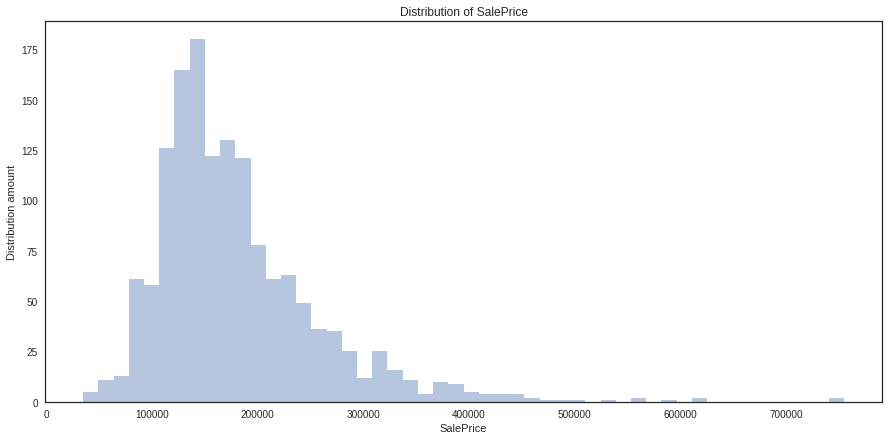

In [65]:
distribution_numreic_features(feature = 'SalePrice', data = data_modell, figsize=(15,7))

When plotting categorical variables we count the features rather than plotting a distribution.

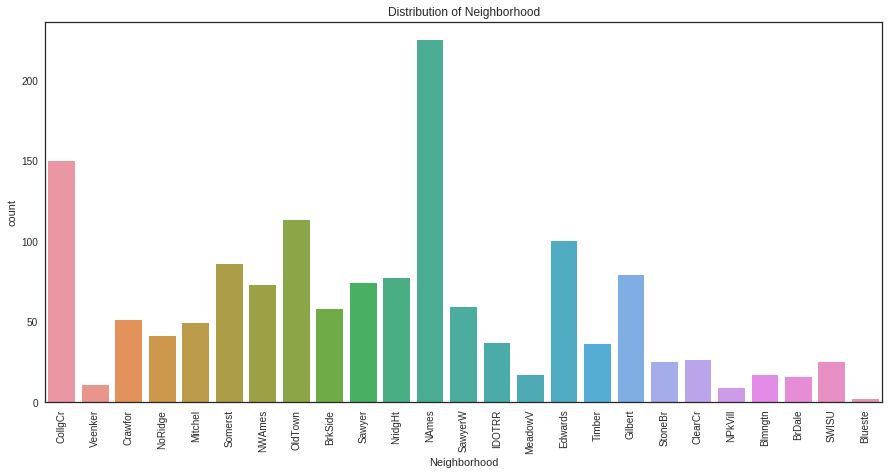

In [66]:
distribution_categorical_features(feature = 'Neighborhood', data = data_modell, figsize=(15,7))

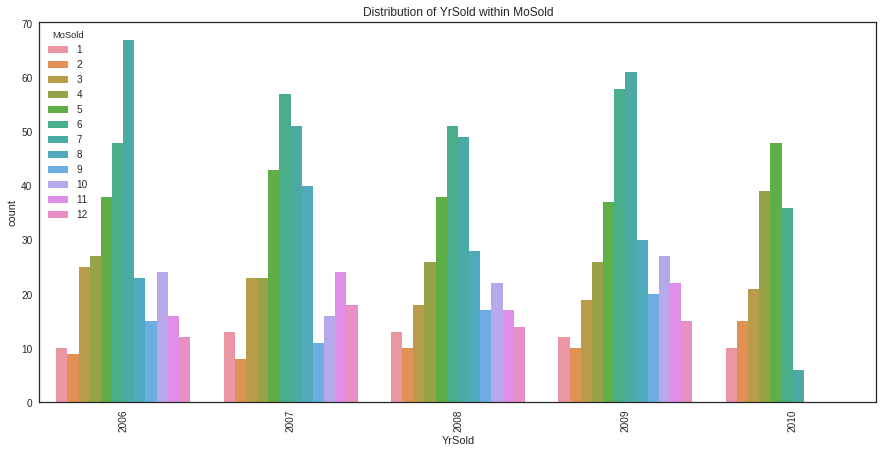

In [67]:
distribution_categorical_features(feature = 'YrSold', sub_feature='MoSold', data = data_modell, figsize=(15,7))

##Algorithms prefer numbers

Algorithms read only number. Therefore, the categorical fetures must be encoded into a numeric labelling. For example, a feature containing 'Yes' and 'No' can be encoded to 0 and 1.



In [103]:
# Encode categorical variables into number
data_modell = encode_variables(data_modell)


data_modell.head(10)

,Id,LotArea,Neighborhood,WoodDeckSF,Condition1,HouseStyle,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Heating,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,Fence,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,PoolArea,PoolQC,MoSold,YrSold,HouseAge,SalePrice
0,1,8450,5,0,2,5,3,7,5,2003,2003,1,856,2,1,3,4,1,8,2,548,0,0,0,2,2008,5,208500
1,2,9600,24,298,1,2,3,6,8,1976,1976,1,1262,2,0,3,4,1,6,2,460,1,0,970,5,2007,31,181500
2,3,11250,5,0,2,5,3,7,5,2001,2002,1,920,2,1,3,4,1,6,2,608,1,0,969,9,2008,7,223500
3,4,9550,6,0,2,5,3,7,5,1915,1970,1,961,1,0,3,4,1,7,3,642,1,0,968,2,2006,91,140000
4,5,14260,15,192,2,5,3,8,5,2000,2000,1,1145,2,1,4,4,1,9,3,836,1,0,967,12,2008,8,250000
5,6,14115,11,40,2,0,3,5,5,1993,1995,1,796,1,1,1,2,1,5,2,480,0,0,966,10,2009,16,143000
6,7,10084,21,255,2,2,3,8,5,2004,2005,1,1694,2,0,3,4,1,7,2,636,1,0,965,8,2007,3,307000
7,8,10382,14,235,4,5,3,7,6,1973,1973,1,1107,2,1,3,4,1,7,2,484,2,0,964,11,2009,36,200000
8,9,6120,17,90,0,0,3,7,5,1931,1950,1,1022,2,0,2,4,2,8,2,468,2,0,963,4,2008,77,129900
9,10,7420,3,0,0,1,3,5,6,1939,1950,1,1077,1,0,2,4,2,5,1,205,2,0,962,1,2008,69,118000


# Select features

## Correlation plot

A correlation plot shows to what degree features change in correlation. If two features have a high correlation, they are somewhat related and have an impact on each other. In other words, they are connected. 

We generally want features that have an impact on the saleprice such that we can use these features to predict the saleprice. 

If a features has a positive correlation with the saleprice, the saleprice will be high when this feature is high (like house area). If a feature has a negative correlation with the saleprice, then the saleprice is high when the feature is low (like house age).

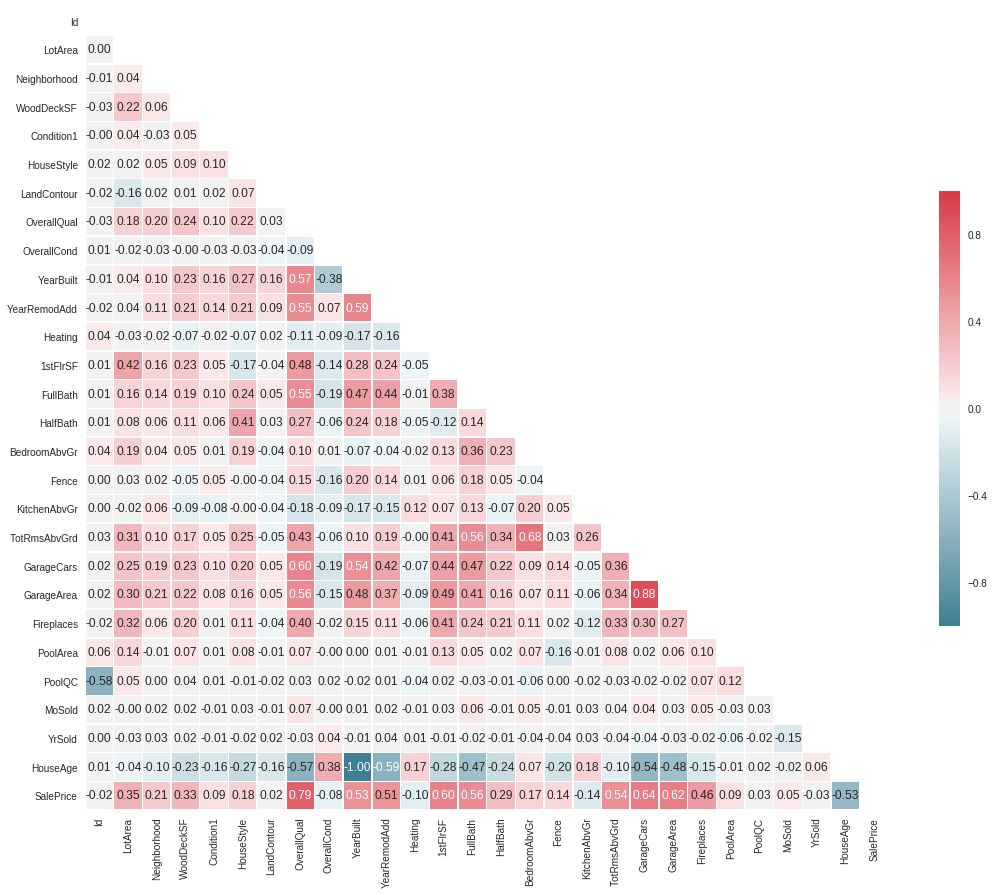

In [69]:
correlation_plot(data = data_modell, figsize = (18,16))

We may also plot variables against the saleprice to see how the correlation look like. This gives an indication of excatly how the features correlate with each other.

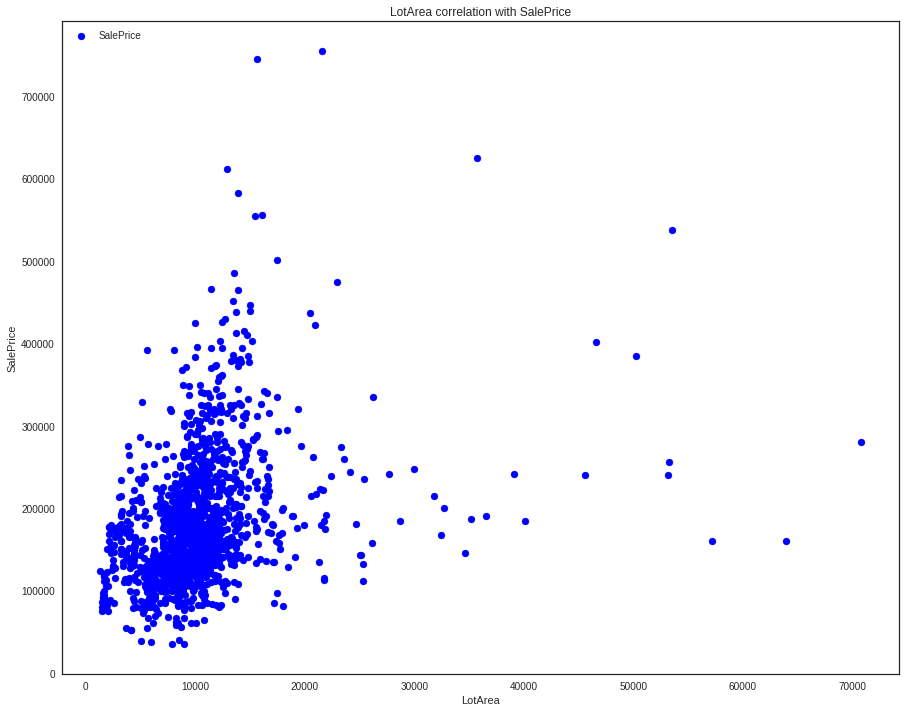

In [70]:
correlation_scatter(feature1 = 'LotArea', feature2 = 'SalePrice', data = data_modell,figsize = (15,12), color = 'blue')

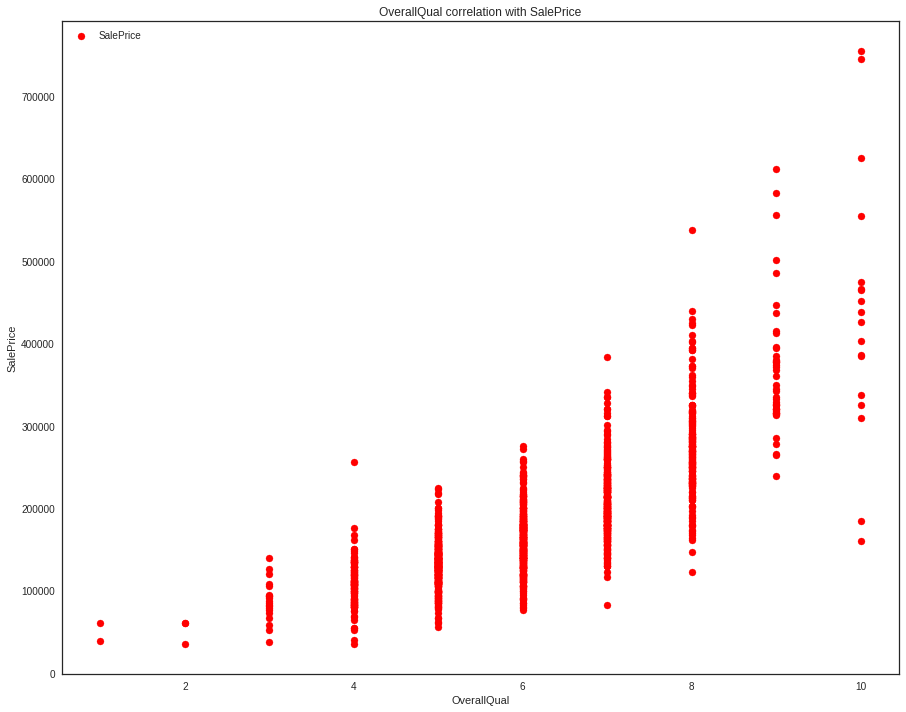

In [44]:
## 
correlation_scatter(feature1 = 'OverallQual', feature2 = 'SalePrice', data = data_modell,figsize = (15,12), color = 'red')

## Create subdataset

We can select features by creating a sub dataset including only the desired features. This is obtained by creating a list of the specific features we want to use.

In [71]:

# Vi dropper unyttige attributter
data_modell_selection = data_modell[['LotArea','Neighborhood','WoodDeckSF','OverallQual','YearBuilt','YearRemodAdd','1stFlrSF','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','GarageCars','GarageArea','Fireplaces','SalePrice']]


## Sjekker at kolonnene med kategoriske features har fått tallverdier
data_modell_selection.head(5)

,LotArea,Neighborhood,WoodDeckSF,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,SalePrice
0,8450,5,0,7,2003,2003,856,2,1,3,8,2,548,0,208500
1,9600,24,298,6,1976,1976,1262,2,0,3,6,2,460,1,181500
2,11250,5,0,7,2001,2002,920,2,1,3,6,2,608,1,223500
3,9550,6,0,7,1915,1970,961,1,0,3,7,3,642,1,140000
4,14260,15,192,8,2000,2000,1145,2,1,4,9,3,836,1,250000


In [13]:
## Info summary of features
data_modell_selection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 15 columns):
LotArea         1456 non-null int64
Neighborhood    1456 non-null int64
WoodDeckSF      1456 non-null int64
OverallQual     1456 non-null int64
YearBuilt       1456 non-null int64
YearRemodAdd    1456 non-null int64
1stFlrSF        1456 non-null int64
FullBath        1456 non-null int64
HalfBath        1456 non-null int64
BedroomAbvGr    1456 non-null int64
TotRmsAbvGrd    1456 non-null int64
GarageCars      1456 non-null int64
GarageArea      1456 non-null int64
Fireplaces      1456 non-null int64
SalePrice       1456 non-null int64
dtypes: int64(15)
memory usage: 182.0 KB


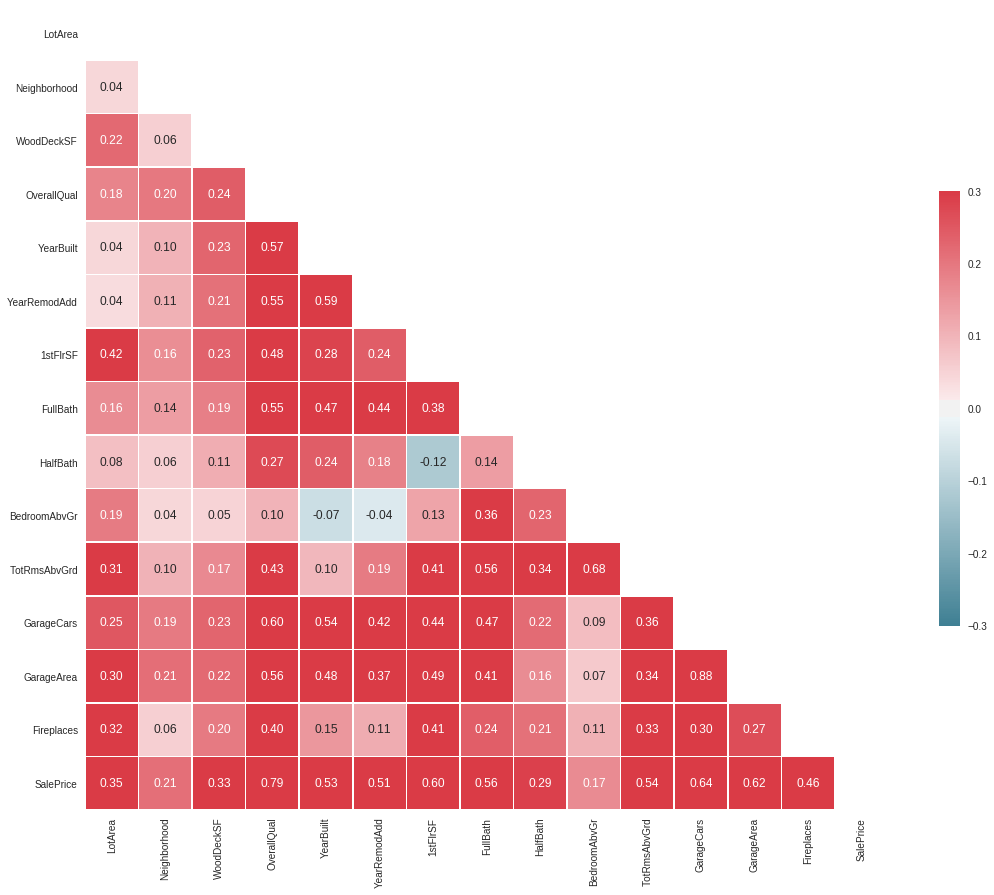

In [37]:
correlation_plot(data = data_modell_selection, figsize = (18,16))

#Machine learning modelling

We typically select machine learning model based on the amount of features and data. Scikit-learn offers a <a href = "http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">  model chart </a> that allows you to easily select the right models to test.


## Dividing into test and train data

First, the data is splitt into two separate data objects <br>
-- **Input**: all the features the model is predicting on <br>
-- **output** the saleprice, or label <br>
<br>
Then, the data is split into a train dataset and test dataset <br>
 -- **Train dataset**: used for training or building the machine learning model <br>
 -- **Test dataset**: used for testing after machine learning model is built (model validation) <br>
 <br>
 This results in a total of 4 datasets

In [78]:
## The data is split into two: Trainingdata and testdata for input and output (4 data objects in total)
input_trainingdata, input_testdata, output_trainingdata, output_testdata = split_data_function(data_modell_selection)


print('Input trainingdata (samples, features): {}, Input testdata (samples, features): {}\n'.format(input_treningsdata.shape, input_testdata.shape)) 
print('Output trainingsdata (samples, label): {}, Output testdata (samples, label): {}\n'.format(output_treningsdata.shape, output_testdata.shape))


Input trainingdata (samples, features): (1164, 14), Input testdata (samples, features): (292, 14)

Output trainingsdata (samples, label): (1164,), Output testdata (samples, label): (292,)



To measure the error on our predictions, we use mean absolute error. This is simply the absolute error between out prediction and the real saleprice over the whole test dataset.

In [0]:
from sklearn.metrics import mean_absolute_error

## Training a linear regression model

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/438px-Linear_regression.svg.png">


This step shows how to use the data to build a macine learning model based using the trainingdata, then test the performance using the testdata.

To build a linear regression model, go to the <a href = "http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html" > sklearn documentation on linear regression </a>. The documentation explains how the model is used in the python script. The sklearn models accept a range of parameters which you can define, or leave to its defaults.



In [95]:
### TRAINING PHASE ###

## The model we want to use is imported. The model name from the documentation is used
from sklearn.linear_model import LinearRegression

## We then create a model object, which is a linear regression model in this case
model_linear_regression = LinearRegression()


## Finally, we train the model by using its built in function 'fit'. The input and output training data is used as parameters
model_linear_regression.fit(input_trainingdata, output_trainingdata)

## We now have a trained machine learning model that is able to predict output (saleprice) from input (features)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
### TEST PHASE ###

## We make predictions on the input from the test data by using the built in function 'predict'. The input testdata is used a parameter
saleprice_predictions_lin_reg = model_linear_regression.predict(input_testdata)

## Finally, we calculate the mean absolute error between output testdata (true saleprice on testdata) and output predictions (predicted saleprice on testdata)
MAE_lin_reg = mean_absolute_error(saleprice_predictions_lin_reg, output_testdata)

## The test error is printed
print("MAE: {}".format(MAE_lin_reg))

MAE: 25651.2306684


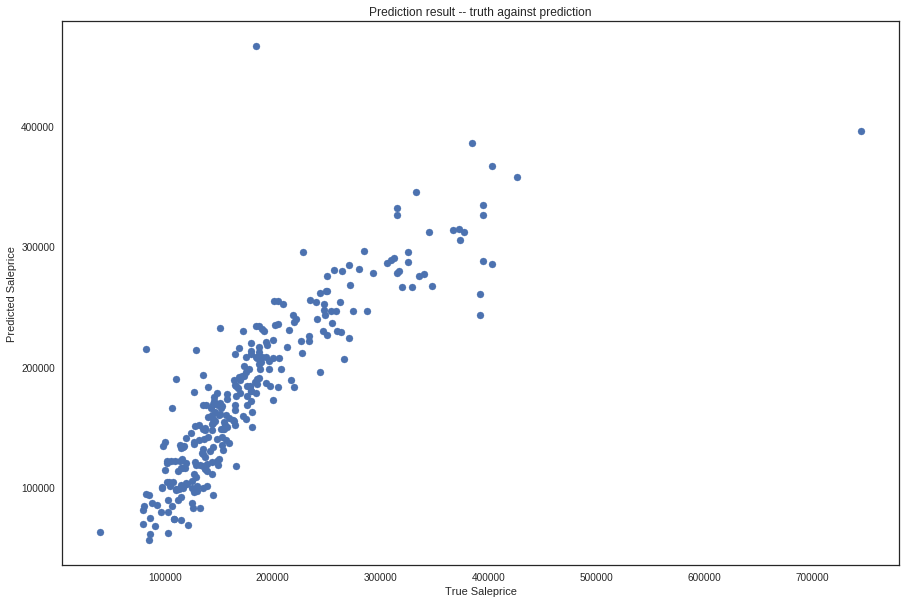

In [90]:
### VISUALIZATION PHASE ###
prediction_result_plot(true_saleprice = output_testdata, predicted_saleprice = saleprice_predictions_lin_reg, figsize=(15, 10))

This is the coding pipeline for creating your own machine learning model. Go to the model chart and test different models using the documentation. Use other documentations as well

In [0]:
## The text strings need to be defined by you ##

#Training
from sklearn.'model type' import 'model'

'model_name' = 'model'

'model_name'.fit(input_trainingdata, output_trainingdata)

#Testing
'predictions_name' = 'model_name'.predict(input_testdata)

'MAE_name' = mean_absolute_error('predictions_name', output_testdata)

print("MAE: {}".format('MAE_name'))

#Visualizing
prediction_result_plot(true_saleprice = output_testdata, predicted_saleprice = 'predictions_name', figsize=(15, 10))

## Decision tree regression

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png">

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html">Scikit-learn decision tree documentation</a>


In [96]:
## Importerer DecisionTreeRegressor fra sklearn
from sklearn.tree import DecisionTreeRegressor

## Creating decision tree model
model_tree = DecisionTreeRegressor()

model_tree.fit(input_trainingdata, output_trainingdata)

saleprice_predictions_tree = model_tree.predict(input_testdata)

MAE_tree = mean_absolute_error(saleprice_predictions_tree, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_tree))

MAE: 31943.3972603


## Lasso regression

<a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html">Scikit-learn decision tree documentation</a>


In [97]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha = 0.1, max_iter=2000)

model_lasso.fit(input_trainingdata, output_trainingdata)

saleprice_predictions_lasso = model_lasso.predict(input_testdata)

MAE_Lasso = mean_absolute_error(saleprice_predictions_lasso, output_testdata)

print("MAE: {}".format(MAE_Lasso))

MAE: 25651.1190553


##Ensemble regression

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

model_boost_reg = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, random_state=1)

model_boost_reg.fit(input_trainingdata, output_trainingdata)

saleprice_predictions_boost_reg = model_boost_reg.predict(input_testdata)

MAE_boost_reg = mean_absolute_error(saleprice_predictions_boost_reg, output_testdata)

print("MAE: {}".format(MAE_boost_reg))

MAE: 21299.080096


#Comparison of results

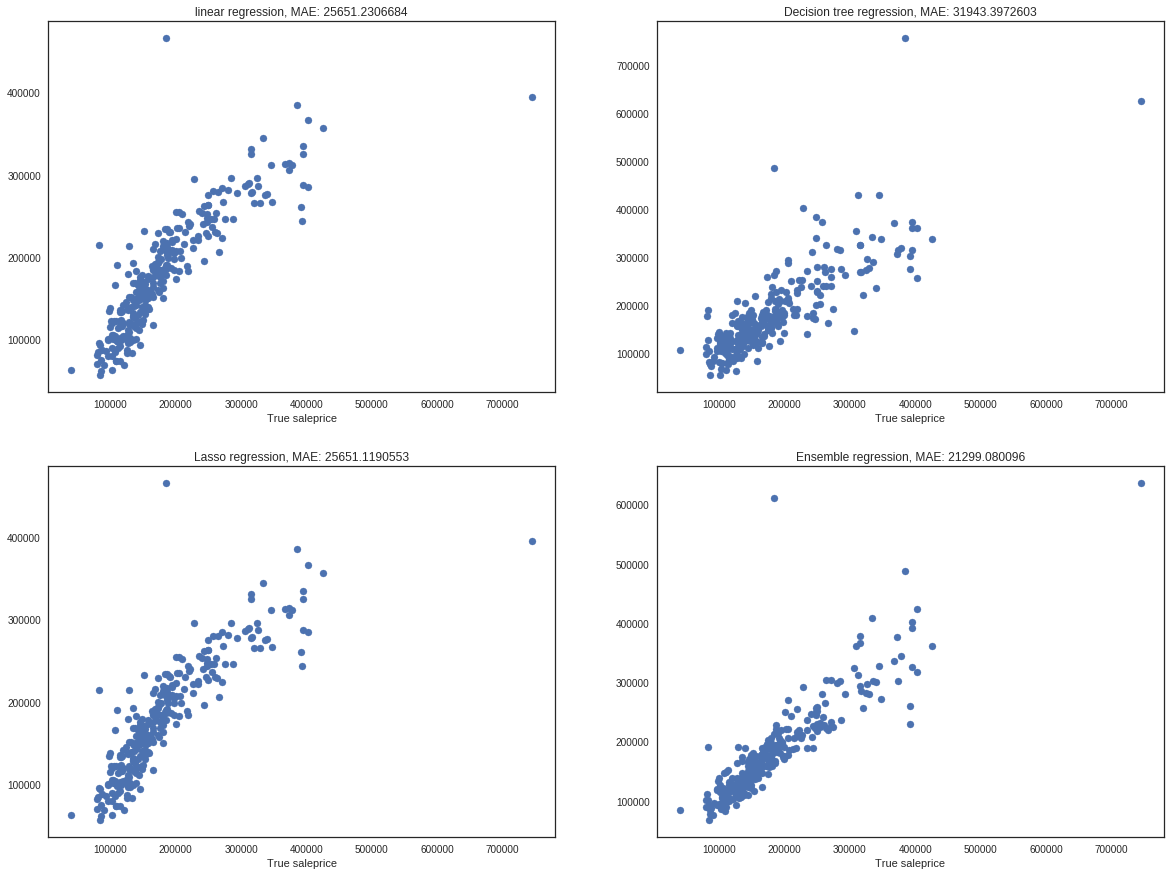

In [100]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.scatter(output_testdata, saleprice_predictions_lin_reg)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('linear regression, MAE: {}'.format(MAE_lin_reg))

plt.subplot(2,2,2)
plt.scatter(output_testdata, saleprice_predictions_tree)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('Decision tree regression, MAE: {}'.format(MAE_tree))

plt.subplot(2,2,3)
plt.scatter(output_testdata, saleprice_predictions_lasso)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('Lasso regression, MAE: {}'.format(MAE_Lasso))

plt.subplot(2,2,4)
plt.scatter(output_testdata, saleprice_predictions_boost_reg)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('Ensemble regression, MAE: {}'.format(MAE_boost_reg))

plt.show()

##What if we use the whole dataset?

In [105]:
input_data = data_modell.iloc[:,0:-1].copy(deep=True)

output_data = data_modell['SalePrice'].copy(deep=True)

print(input_data.shape)

input_treningsdata, input_testdata, output_treningsdata, output_testdata = train_test_split(input_data, output_data, test_size=0.2, random_state=1)


from sklearn.linear_model import LinearRegression

model_lin_reg_2 = LinearRegression()

model_lin_reg_2.fit(input_treningsdata, output_treningsdata)

saleprice_predictions_lin_reg_2 = model_lin_reg_2.predict(input_testdata)

MAE_lin_reg_2 = mean_absolute_error(saleprice_predictions_lin_reg_2, output_testdata)

print("MAE: {}".format(MAE_lin_reg_2))


from sklearn.ensemble import GradientBoostingRegressor

model_boost_reg_2 = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, random_state=1)

model_boost_reg_2.fit(input_trainingdata, output_trainingdata)

saleprice_predictions_boost_reg_2 = model_boost_reg_2.predict(input_testdata)

MAE_boost_reg_2 = mean_absolute_error(saleprice_predictions_boost_reg_2, output_testdata)

print("MAE: {}".format(MAE_boost_reg))

(1456, 27)
MAE: 25825.0465779


ValueError: ignored

NameError: ignored

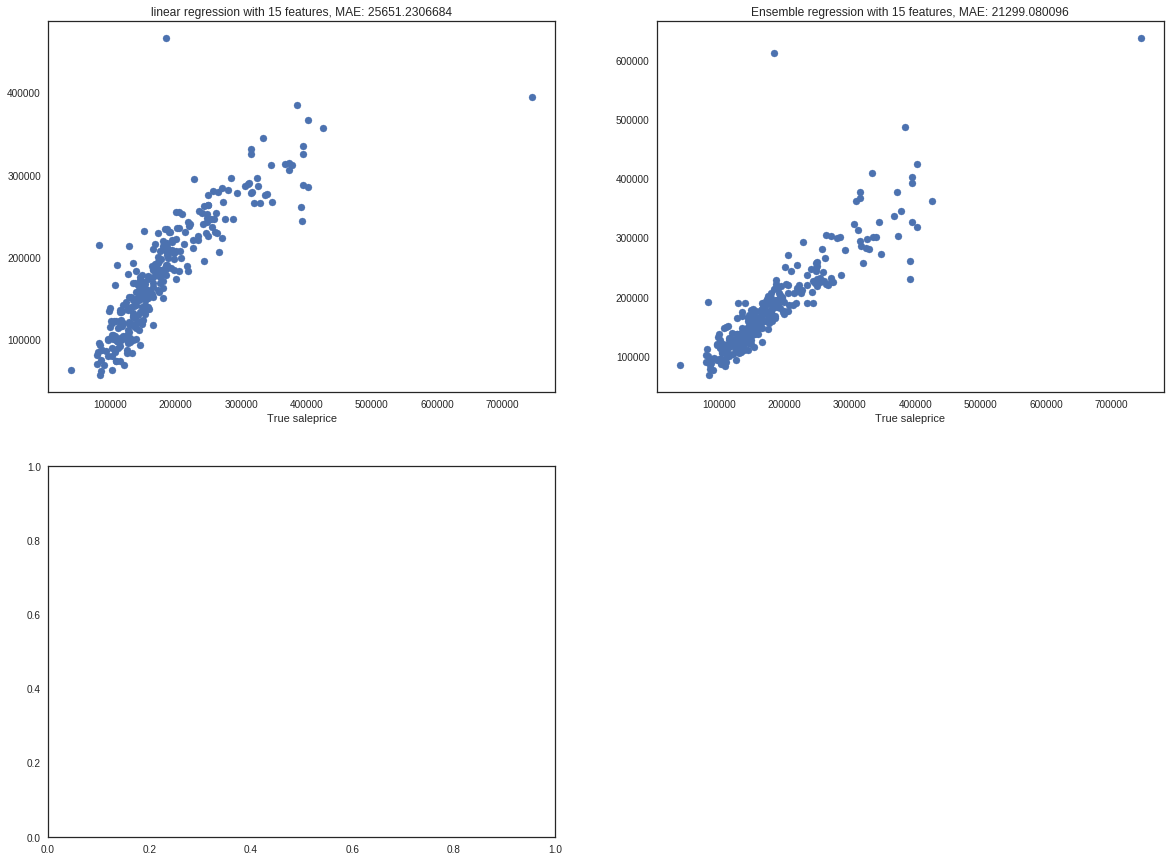

In [101]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.scatter(output_testdata, saleprice_predictions_lin_reg)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('linear regression with {} features, MAE: {}'.format(len(data_modell_selection.columns), MAE_lin_reg))

plt.subplot(2,2,2)
plt.scatter(output_testdata, saleprice_predictions_boost_reg)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('Ensemble regression with {} features, MAE: {}'.format(len(data_modell_selection.columns), MAE_boost_reg))

plt.subplot(2,2,3)
plt.scatter(output_testdata, saleprice_predictions_lin_reg_2)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('linear regression with {} features, MAE: {}'.format(len(data_modell.columns), MAE_lin_reg_2))

plt.subplot(2,2,4)
plt.scatter(output_testdata, saleprice_predictions_boost_reg_2)
plt.xlabel('Prediction saleprice')
plt.xlabel('True saleprice')
plt.title('Ensemble regression with {} features, MAE: {}'.format(len(data_modell.columns), MAE_boost_reg_2))

plt.show()